In [1]:
import pickle
import os
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from genbench3d.sb_model import LiGAN, ThreeDSBDD, Pocket2Mol, TargetDiff, DiffSBDD, ResGen

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/rdkit/Chem/MolStandardize/__init__.

In [2]:
config_path = './config/default.yaml'
config = yaml.safe_load(open(config_path, 'r'))

In [3]:
with open('test_set/ligand_filenames.txt', 'r') as f:
    ligand_filenames = f.readlines()
ligand_filenames = [ligand_filename.strip() for ligand_filename in ligand_filenames]

models = [
            LiGAN(gen_path=config['models']['ligan_gen_dirpath'],
                  minimized_path=config['data']['minimized_path'],
                  ligand_filenames=ligand_filenames),
            ThreeDSBDD(gen_path=config['models']['threedsbdd_gen_dirpath'],
                       minimized_path=config['data']['minimized_path']),
            Pocket2Mol(gen_path=config['models']['pocket2mol_gen_dirpath'],
                       minimized_path=config['data']['minimized_path']),
            TargetDiff(results_path=config['models']['targetdiff_results_filepath'],
                       minimized_path=config['data']['minimized_path']),
            DiffSBDD(gen_path=config['models']['diffsbdd_gen_dirpath'],
                     minimized_path=config['data']['minimized_path']),
            ResGen(gen_path=config['models']['resgen_gen_dirpath'],
                   minimized_path=config['data']['minimized_path'])
            ]

model_names = [model.name for model in models]
set_names = model_names + ['CrossDocked (training)', 'CSD Drug subset']

In [4]:
results_dir = config['results_dir']
filepaths = []
for model in models:
    filename = f'results_{model.name}.p'
    filepath = os.path.join(results_dir, filename)
    filepaths.append(filepath)
    filename = f'results_{model.name}_minimized.p'
    filepath = os.path.join(results_dir, filename)
    filepaths.append(filepath)

In [5]:
filepaths.append(os.path.join(results_dir, 'results_CrossDocked_train.p'))
# filepaths.append(os.path.join(results_dir, 'results_CrossDocked_test.p'))
filepaths.append(os.path.join(results_dir, 'results_CSDDrug.p'))

In [6]:
filepaths

['/home/bb596/hdd/genbench3d/results/results_LiGAN.p',
 '/home/bb596/hdd/genbench3d/results/results_LiGAN_minimized.p',
 '/home/bb596/hdd/genbench3d/results/results_3D_SBDD.p',
 '/home/bb596/hdd/genbench3d/results/results_3D_SBDD_minimized.p',
 '/home/bb596/hdd/genbench3d/results/results_Pocket2Mol.p',
 '/home/bb596/hdd/genbench3d/results/results_Pocket2Mol_minimized.p',
 '/home/bb596/hdd/genbench3d/results/results_TargetDiff.p',
 '/home/bb596/hdd/genbench3d/results/results_TargetDiff_minimized.p',
 '/home/bb596/hdd/genbench3d/results/results_DiffSBDD.p',
 '/home/bb596/hdd/genbench3d/results/results_DiffSBDD_minimized.p',
 '/home/bb596/hdd/genbench3d/results/results_ResGen.p',
 '/home/bb596/hdd/genbench3d/results/results_ResGen_minimized.p',
 '/home/bb596/hdd/genbench3d/results/results_CrossDocked_train.p',
 '/home/bb596/hdd/genbench3d/results/results_CSDDrug.p']

In [7]:
rows = []
for filepath in filepaths:
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    model_name = '_'.join(filepath.split('_')[1:]).split('.')[0]
    minimized = False
    if 'minimized' in model_name:
        minimized = True
        model_name = '_'.join(model_name.split('_')[:-1])
    row = {'Model' : model_name,
          'Relaxed': minimized}
    # if ('DiffSBDD' in filepath) and (not 'minimized' in filepath):
    #     import pdb;pdb.set_trace()
    for name, values in results.items():
        
        if 'Validity3D CSD' in name:
                name = name.replace('Validity3D CSD', 'Validity3D')
            
        if isinstance(values, dict):
            for k, v in values.items():
                row[name+str(k)] = v
        if isinstance(values, list):
            value = np.nanmedian(values)
            row[name] = value
        else:
            value = values
            row[name] = value
    rows.append(row)

In [8]:
df = pd.DataFrame(rows)
df['Molecule set'] = df['Model'].replace('CrossDocked_train', 'CrossDocked (training)').replace('CSDDrug', 'CSD Drug subset').replace('CrossDocked_test', 'CrossDocked (test)').replace('3D_SBDD', '3D-SBDD').replace('CrossDocked', 'CrossDocked (training)')

In [9]:
model_order = ['LiGAN', '3D-SBDD', 'Pocket2Mol', 'TargetDiff', 'DiffSBDD', 'ResGen',]
order = model_order + ['CrossDocked (training)', 
               # 'CrossDocked (test)', 
               'CSD Drug subset']
df['Molecule set'] = pd.Categorical(df['Molecule set'], order)
df = df.dropna(subset=['Molecule set'])

In [10]:
large_rings = None
for column in df.columns:
    if 'Ring' in column:
        split = column.split('proportion')
        if len(split) > 1 and split[-1] != '':
            size = int(split[-1])
            if size > 7 :
                column_data = df[column].fillna(0)
                if large_rings is None:
                    large_rings = column_data
                else:
                    large_rings = large_rings + column_data
df['Ring proportion>7'] = large_rings

In [11]:
nonmin_df = df[~df['Relaxed']]

In [12]:
nonmin_df.keys()

Index(['Model', 'Relaxed', 'Validity2D', 'Uniqueness2D', 'Diversity2D',
       'Ring proportion5', 'Ring proportion6', 'Ring proportion3',
       'Ring proportion4', 'Ring proportion9', 'Ring proportion7',
       'Ring proportion8', 'Ring proportion13', 'Ring proportion16',
       'Ring proportion11', 'Ring proportion14', 'Ring proportion10',
       'Ring proportion18', 'Ring proportion12', 'Ring proportion15',
       'Ring proportion', 'MW', 'logP', 'SAScore', 'QED', 'Novelty2D',
       'Maximum training similarity', 'Validity3D', 'Strain energy',
       'Number of tested confs', 'Uniqueness3D', 'Diversity3D', 'Novelty3D',
       'Number of valid 3D confs (Validity3D)',
       'Number of invalid bonds (Validity3D)',
       'Number of invalid angles (Validity3D)',
       'Number of invalid torsions (Validity3D)',
       'Number of invalid rings (Validity3D)',
       'Number of new patterns (Validity3D)',
       'Number of new unique patterns (Validity3D)',
       'Min bond q-value (Val

In [13]:
nonmin_df[['Molecule set', 
           'Validity2D', 
           'Uniqueness2D', 
           'Diversity2D',
           'Novelty2D',
           'Maximum training similarity',
          'MW', 'logP', 'SAScore', 'QED',
          'Number of tested confs']]

,Molecule set,Validity2D,Uniqueness2D,Diversity2D,Novelty2D,Maximum training similarity,MW,logP,SAScore,QED,Number of tested confs
0,LiGAN,0.745921,0.996296,0.923207,1.0,0.180000,228.3010,0.56115,4.943085,0.466669,5669
2,3D-SBDD,0.798024,0.933135,0.936345,1.0,0.177215,262.3530,0.15934,4.997865,0.465470,6057
4,Pocket2Mol,0.980120,0.921153,0.919027,1.0,0.254545,257.2785,1.46875,2.908105,0.600442,6557
6,TargetDiff,1.000000,0.990685,0.923308,1.0,0.176471,368.4410,1.62810,4.877583,0.478660,6763
8,DiffSBDD,1.000000,0.999211,0.921710,1.0,0.166667,342.4320,2.62630,5.012516,0.468308,7600
10,ResGen,1.000000,0.892895,0.916748,1.0,0.269231,262.3290,1.44305,2.815510,0.606718,7600
12,CrossDocked (training),1.000000,0.087660,0.924641,NaN,NaN,353.4125,2.39220,3.184299,0.531919,100000
13,CSD Drug subset,1.000000,0.315073,0.940952,NaN,NaN,266.2130,1.07712,3.656810,0.554717,8452


In [14]:
nonmin_df[['Molecule set', 
           'Ring proportion3', 
           'Ring proportion4', 
           'Ring proportion5',
          'Ring proportion6',
          'Ring proportion7',
          'Ring proportion>7']].round(4).sort_values('Molecule set')

,Molecule set,Ring proportion3,Ring proportion4,Ring proportion5,Ring proportion6,Ring proportion7,Ring proportion>7
0,LiGAN,0.5988,0.1485,0.1369,0.0823,0.0147,0.0188
2,3D-SBDD,0.4688,0.0017,0.1368,0.3381,0.0210,0.0335
4,Pocket2Mol,0.0010,0.0004,0.1954,0.7680,0.0245,0.0106
6,TargetDiff,NaN,0.0269,0.2928,0.4962,0.1157,0.0684
8,DiffSBDD,0.3022,0.0465,0.1953,0.3335,0.0860,0.0365
10,ResGen,0.0002,0.0001,0.1963,0.7812,0.0131,0.0091
12,CrossDocked (training),0.0147,0.0030,0.2715,0.6955,0.0081,0.0072
13,CSD Drug subset,0.0078,0.0107,0.1838,0.7132,0.0164,0.0681


In [15]:
nonmin_df[['Molecule set', 
           'Uniqueness3D', 
           'Diversity3D', 
           'Novelty3D']].round(4).sort_values('Molecule set')

,Molecule set,Uniqueness3D,Diversity3D,Novelty3D
0,LiGAN,NaN,NaN,NaN
2,3D-SBDD,0.2397,0.2478,NaN
4,Pocket2Mol,0.5873,0.2961,NaN
6,TargetDiff,0.7568,0.4925,NaN
8,DiffSBDD,NaN,NaN,NaN
10,ResGen,0.5268,0.3243,NaN
12,CrossDocked (training),0.0960,0.0861,NaN
13,CSD Drug subset,0.1929,0.1041,NaN


In [16]:
nonmin_df[['Molecule set', 
           'Validity3D', 
           'Min bond q-value (Validity3D)',
           'Min angle q-value (Validity3D)',
           # 'Min torsion q-value (Validity3D CSD)',
           'Min bond+angle q-value (Validity3D)',
           # 'Min bond+angle+torsion q-value (Validity3D CSD)',
           'Geometric mean bond q-value (Validity3D)',
           'Geometric mean angle q-value (Validity3D)',
           # 'Geometric mean torsion q-value (Validity3D CSD)',
           'Geometric mean bond+angle q-value (Validity3D)',
           # 'Geometric mean bond+angle+torsion q-value (Validity3D CSD)',
          'Strain energy']].round(4).sort_values('Molecule set')

,Molecule set,Validity3D,Min bond q-value (Validity3D),Min angle q-value (Validity3D),Min bond+angle q-value (Validity3D),Geometric mean bond q-value (Validity3D),Geometric mean angle q-value (Validity3D),Geometric mean bond+angle q-value (Validity3D),Strain energy
0,LiGAN,0.0224,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1539.7308
2,3D-SBDD,0.0650,0.0000,0.0000,0.0000,0.0099,0.0000,0.0001,369.3006
4,Pocket2Mol,0.0314,0.0000,0.0000,0.0000,0.0004,0.0186,0.0023,144.5591
6,TargetDiff,0.0470,0.0000,0.0000,0.0000,0.0270,0.0002,0.0010,377.5181
8,DiffSBDD,0.0025,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2003.6691
10,ResGen,0.0401,0.0000,0.0000,0.0000,0.0006,0.0281,0.0035,143.3241
12,CrossDocked (training),0.4821,0.0054,0.0067,0.0008,0.3304,0.3738,0.3310,56.1069
13,CSD Drug subset,0.9891,0.2413,0.2303,0.1432,0.7248,0.7283,0.7197,120.0858


<Axes: xlabel='Strain energy', ylabel='Molecule set'>

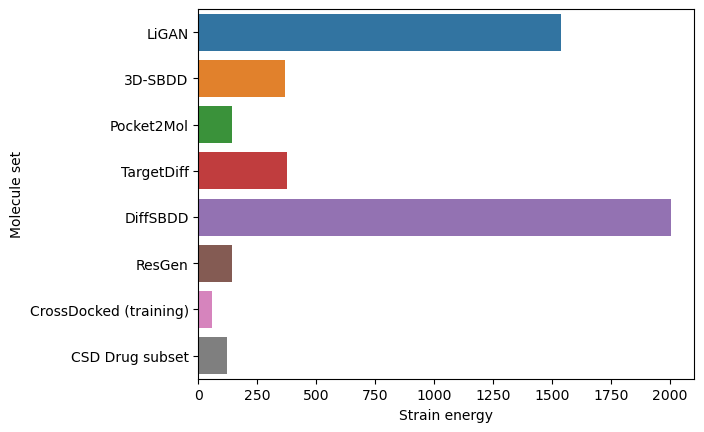

In [17]:
sns.barplot(data=nonmin_df, 
            x='Strain energy',
            y='Molecule set')

In [18]:
pastel_palette = sns.color_palette("pastel")
colorblind_palette = sns.color_palette("colorblind")

In [19]:
colorblind_palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [20]:
current_palette = pastel_palette[:6] + colorblind_palette[:6] + pastel_palette[6:8]

In [21]:
df['Number of valid 3D confs (Validity3D)'] / df['Number of tested confs']

0     0.022403
1     0.542241
2     0.065049
3     0.681167
4     0.031417
5     0.774863
6     0.047021
7     0.520077
8     0.002500
9     0.513966
10    0.040132
11    0.687014
12    0.482070
13    0.989115
dtype: float64

In [22]:
df['Number of valid 3D confs (Validity3D)']

0       127
1      2991
2       394
3      4087
4       206
5      5080
6       318
7      3510
8        19
9      3901
10      305
11     5211
12    48207
13     8360
Name: Number of valid 3D confs (Validity3D), dtype: int64

In [23]:
df['Number of tested confs']

0       5669
1       5516
2       6057
3       6000
4       6557
5       6556
6       6763
7       6749
8       7600
9       7590
10      7600
11      7585
12    100000
13      8452
Name: Number of tested confs, dtype: int64

In [24]:
df[['Molecule set', 'Relaxed', 'Validity3D']]

,Molecule set,Relaxed,Validity3D
0,LiGAN,False,0.022403
1,LiGAN,True,0.542241
2,3D-SBDD,False,0.065049
3,3D-SBDD,True,0.681167
4,Pocket2Mol,False,0.031417
5,Pocket2Mol,True,0.774863
6,TargetDiff,False,0.047021
7,TargetDiff,True,0.520077
8,DiffSBDD,False,0.002500
9,DiffSBDD,True,0.513966


In [25]:
sns.set_palette('colorblind')
sns.set_context('talk', 
                # rc = {'patch.linewidth': 5.0}
               )

In [26]:
hatches = ['', '//']

In [27]:
plt.show()

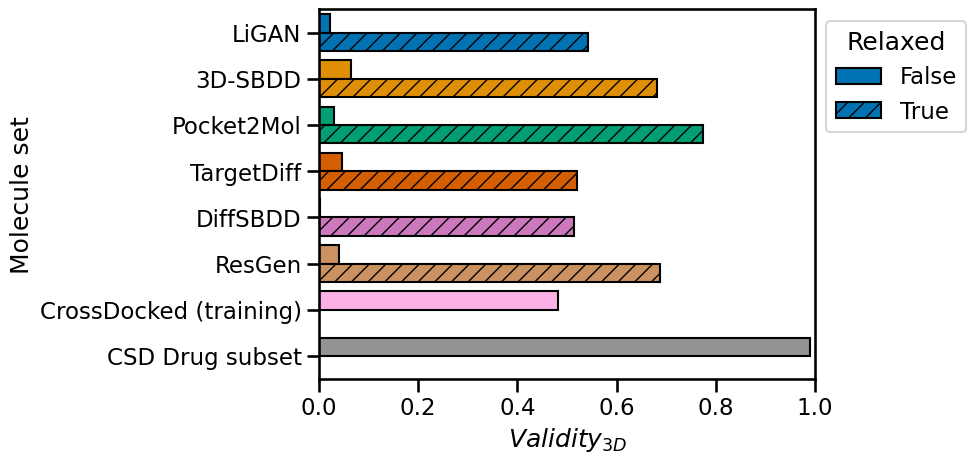

In [28]:
from matplotlib.legend_handler import HandlerTuple
ax = sns.barplot(data=df,
    # data=df[df['Molecule set'].isin(model_names)].round(2),
                 x='Validity3D',
                 y='Molecule set',
                 hue='Relaxed',
                 order=order,
                 edgecolor='black'
                )
for bars, colors, hatch in zip(ax.containers, (colorblind_palette, colorblind_palette), hatches):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)

# for bars, hatch in zip(ax.containers, hatches):
#      for bar in bars:
#           bar.set_hatch(hatch)
title = 'Subset'
labels = ['Raw', 'Relaxed']
ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), title='Relaxed')

# ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],
#           labels=labels,
#           title=title,
#           handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)},
#          loc="upper left", 
#               bbox_to_anchor=(1, 1))
plt.xlim(0, 1)
plt.xlabel('$Validity_{3D}$')
plt.savefig('figures/Validity3D.png', dpi=300, bbox_inches='tight')
# for container in ax.containers:
#     ax.bar_label(container)

In [29]:
df.columns

Index(['Model', 'Relaxed', 'Validity2D', 'Uniqueness2D', 'Diversity2D',
       'Ring proportion5', 'Ring proportion6', 'Ring proportion3',
       'Ring proportion4', 'Ring proportion9', 'Ring proportion7',
       'Ring proportion8', 'Ring proportion13', 'Ring proportion16',
       'Ring proportion11', 'Ring proportion14', 'Ring proportion10',
       'Ring proportion18', 'Ring proportion12', 'Ring proportion15',
       'Ring proportion', 'MW', 'logP', 'SAScore', 'QED', 'Novelty2D',
       'Maximum training similarity', 'Validity3D', 'Strain energy',
       'Number of tested confs', 'Uniqueness3D', 'Diversity3D', 'Novelty3D',
       'Number of valid 3D confs (Validity3D)',
       'Number of invalid bonds (Validity3D)',
       'Number of invalid angles (Validity3D)',
       'Number of invalid torsions (Validity3D)',
       'Number of invalid rings (Validity3D)',
       'Number of new patterns (Validity3D)',
       'Number of new unique patterns (Validity3D)',
       'Min bond q-value (Val

In [30]:
df['AvDiv3D'] = df['Diversity3D'] 

In [31]:
plt.rcParams.update({'mathtext.default':  'regular' })

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


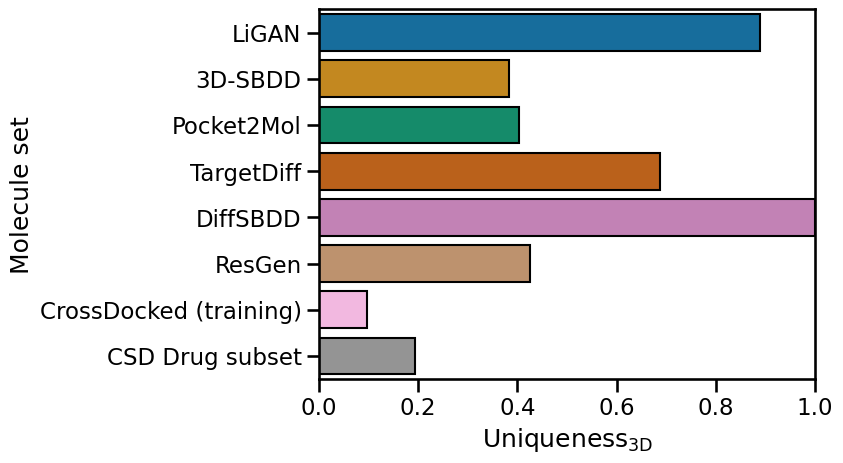

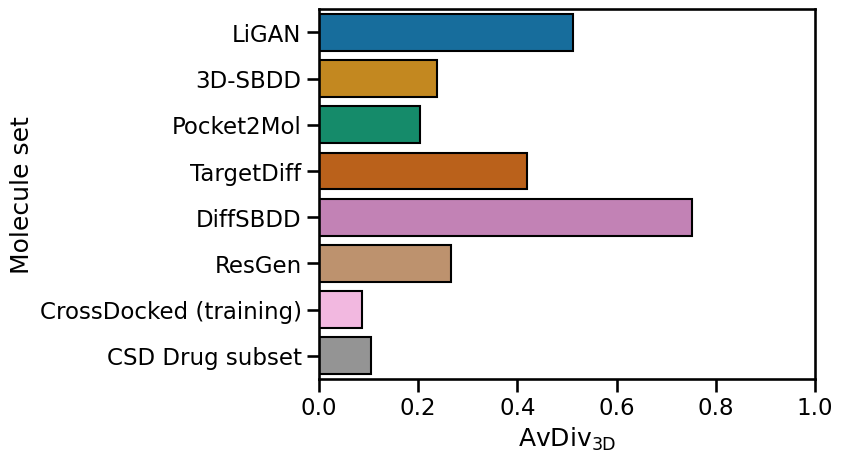

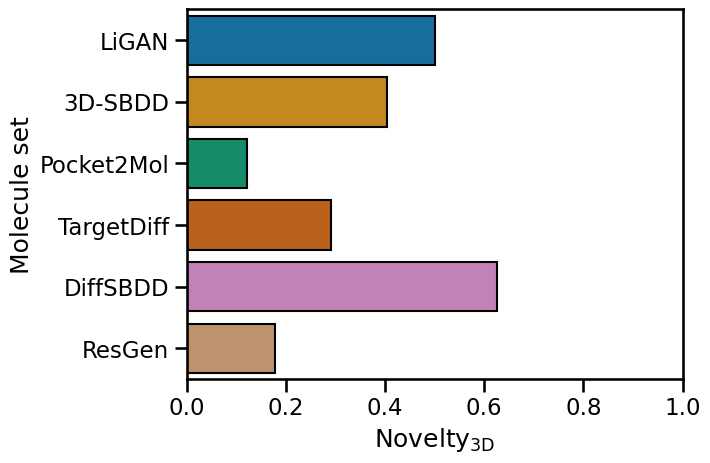

In [32]:
from matplotlib.legend_handler import HandlerTuple
subset_df = df[(df['Relaxed'] == True) | ~(df['Molecule set'].isin(model_order))]
for metric in ['Uniqueness3D', 'AvDiv3D', 'Novelty3D']:
    if metric == 'Novelty3D':
        names = model_order
    else:
        names = order
        
    ax = sns.barplot(
        # data=df[df['Molecule set'].isin(model_names)].round(2),
                data=subset_df,
               x=metric,
               y='Molecule set',
               # hue='Relaxed',
                palette=colorblind_palette,
               order=names,
        # color = sns.color_palette()[0],
        edgecolor='black'
    )
    # for bars, colors in zip(ax.containers, (pastel_palette, colorblind_palette)):
    #      for bar, color in zip(bars, colors):
    #           bar.set_facecolor(color)
    # ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],
    #           labels=[bar_group.get_label() for bar_group in ax.containers],
    #           title=ax.legend_.get_title().get_text(),
    #           handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)})
    plt.xlim(0, 1)
    pretty_metric_name = '$' + metric.replace('3D', '_{3D}') + '$'
    plt.xlabel(pretty_metric_name)
    plt.savefig(f'figures/{metric}.png', dpi=300, bbox_inches='tight')
    plt.show()
    # for container in ax.containers:
    #     ax.bar_label(container)

In [33]:
colorblind_palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [34]:
df[df['Molecule set'].isin(model_order)][['Model', 'Relaxed', 'Validity3D']]

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


,Model,Relaxed,Validity3D
0,LiGAN,False,0.022403
1,LiGAN,True,0.542241
2,3D_SBDD,False,0.065049
3,3D_SBDD,True,0.681167
4,Pocket2Mol,False,0.031417
5,Pocket2Mol,True,0.774863
6,TargetDiff,False,0.047021
7,TargetDiff,True,0.520077
8,DiffSBDD,False,0.002500
9,DiffSBDD,True,0.513966


In [35]:
min_df = df[df['Relaxed']]

In [36]:
min_df[['Molecule set', 
           'Uniqueness3D', 
           'Diversity3D', 
           'Novelty3D']].round(4).sort_values('Molecule set')

,Molecule set,Uniqueness3D,Diversity3D,Novelty3D
1,LiGAN,0.8889,0.5115,0.5000
3,3D-SBDD,0.3831,0.2377,0.4045
5,Pocket2Mol,0.4031,0.2029,0.1226
7,TargetDiff,0.6875,0.4198,0.2909
9,DiffSBDD,1.0000,0.7528,0.6250
11,ResGen,0.4249,0.2663,0.1776


In [37]:
min_df[['Molecule set', 
           'Validity3D', 
           'Min bond q-value (Validity3D)',
           'Min angle q-value (Validity3D)',
           # 'Min torsion q-value (Validity3D CSD)',
           'Min bond+angle q-value (Validity3D)',
           # 'Min bond+angle+torsion q-value (Validity3D CSD)',
           'Geometric mean bond q-value (Validity3D)',
           'Geometric mean angle q-value (Validity3D)',
           # 'Geometric mean torsion q-value (Validity3D CSD)',
           'Geometric mean bond+angle q-value (Validity3D)',
           # 'Geometric mean bond+angle+torsion q-value (Validity3D CSD)',
          'Strain energy']].round(4).sort_values('Molecule set')

,Molecule set,Validity3D,Min bond q-value (Validity3D),Min angle q-value (Validity3D),Min bond+angle q-value (Validity3D),Geometric mean bond q-value (Validity3D),Geometric mean angle q-value (Validity3D),Geometric mean bond+angle q-value (Validity3D),Strain energy
1,LiGAN,0.5422,0.0357,0.0043,0.0027,0.3630,0.1595,0.2443,31.1875
3,3D-SBDD,0.6812,0.0709,0.0159,0.0123,0.5147,0.3095,0.3973,16.5761
5,Pocket2Mol,0.7749,0.0774,0.0210,0.0144,0.5725,0.4379,0.4832,10.9790
7,TargetDiff,0.5201,0.0271,0.0022,0.0015,0.4509,0.2488,0.3236,30.5282
9,DiffSBDD,0.5140,0.0444,0.0017,0.0014,0.4816,0.2111,0.3132,37.8926
11,ResGen,0.6870,0.0546,0.0117,0.0078,0.5281,0.3619,0.4195,14.3495


In [38]:
nonmin_df[~nonmin_df['Molecule set'].isin(model_order)][['Molecule set', 
           'Validity3D', 
           'Min bond q-value (Validity3D)',
           'Min angle q-value (Validity3D)',
           'Min torsion q-value (Validity3D)',
           'Min bond+angle q-value (Validity3D)',
           'Min bond+angle+torsion q-value (Validity3D)',
           'Geometric mean bond q-value (Validity3D)',
           'Geometric mean angle q-value (Validity3D)',
           'Geometric mean torsion q-value (Validity3D)',
           'Geometric mean bond+angle q-value (Validity3D)',
           'Geometric mean bond+angle+torsion q-value (Validity3D)',
          'Strain energy']].round(4).sort_values('Molecule set')

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


,Molecule set,Validity3D,Min bond q-value (Validity3D),Min angle q-value (Validity3D),Min torsion q-value (Validity3D),Min bond+angle q-value (Validity3D),Min bond+angle+torsion q-value (Validity3D),Geometric mean bond q-value (Validity3D),Geometric mean angle q-value (Validity3D),Geometric mean torsion q-value (Validity3D),Geometric mean bond+angle q-value (Validity3D),Geometric mean bond+angle+torsion q-value (Validity3D),Strain energy
12,CrossDocked (training),0.4821,0.0054,0.0067,0.0003,0.0008,0.0000,0.3304,0.3738,0.3225,0.3310,0.3001,56.1069
13,CSD Drug subset,0.9891,0.2413,0.2303,0.2489,0.1432,0.0975,0.7248,0.7283,0.7548,0.7197,0.7162,120.0858


In [39]:
min_rows = []
for filepath in filepaths:
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    model_name = '_'.join(filepath.split('_')[1:]).split('.')[0]
    minimized = False
    if 'minimized' in model_name:
        minimized = True
        model_name = '_'.join(model_name.split('_')[:-1])
    for name, values in results.items():

        if 'Validity3D CSD' in name:
                name = name.replace('Validity3D CSD', 'Validity3D')
        
        if 'Min' in name:
            for value in values:
                row = {'Model' : model_name,
                      'Minimized': minimized,
                      'Name': name,
                      'Value': value}
                min_rows.append(row)

In [40]:
min_df = pd.DataFrame(min_rows)

In [41]:
min_df['Name'].unique()

array(['Min bond q-value (Validity3D)', 'Min angle q-value (Validity3D)',
       'Min torsion q-value (Validity3D)',
       'Min bond+angle q-value (Validity3D)',
       'Min bond+angle+torsion q-value (Validity3D)'], dtype=object)

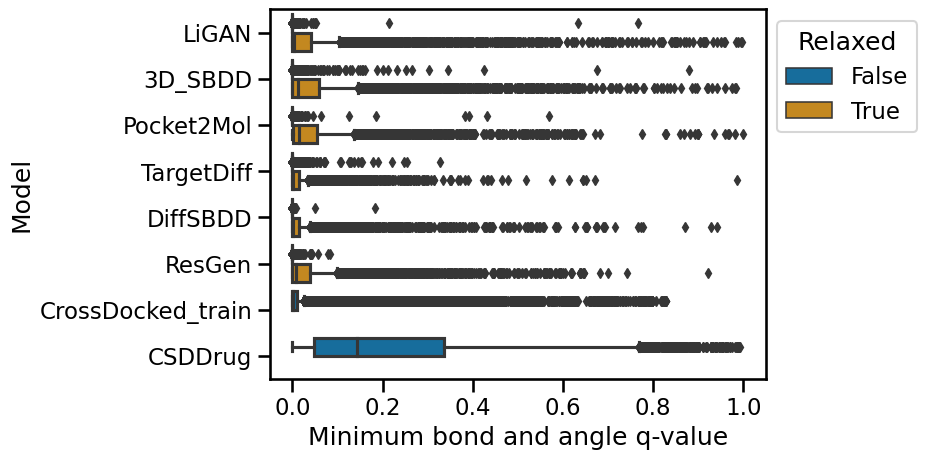

In [42]:
ax = sns.boxplot(data=min_df[min_df['Name'] == 'Min bond+angle q-value (Validity3D)'],
           x='Value',
           y='Model',
           hue='Minimized')
for bars, colors, hatch in zip(ax.containers, (colorblind_palette, colorblind_palette), hatches):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)

# for bars, hatch in zip(ax.containers, hatches):
#      for bar in bars:
#           bar.set_hatch(hatch)
title = 'Subset'
labels = ['Raw', 'Relaxed']
ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), title='Relaxed')

# ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],
#           labels=labels,
#           title=title,
#           handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)},
#          loc="upper left", 
#               bbox_to_anchor=(1, 1))
# plt.xlim(0, 1)
plt.xlabel('Minimum bond and angle q-value')
plt.savefig('figures/min_q_values.png', dpi=300, bbox_inches='tight')
# for container in ax.containers:
#     ax.bar_label(container)

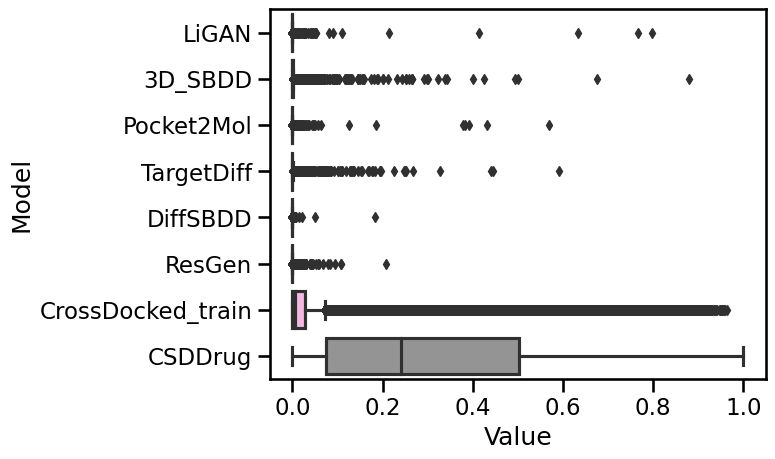

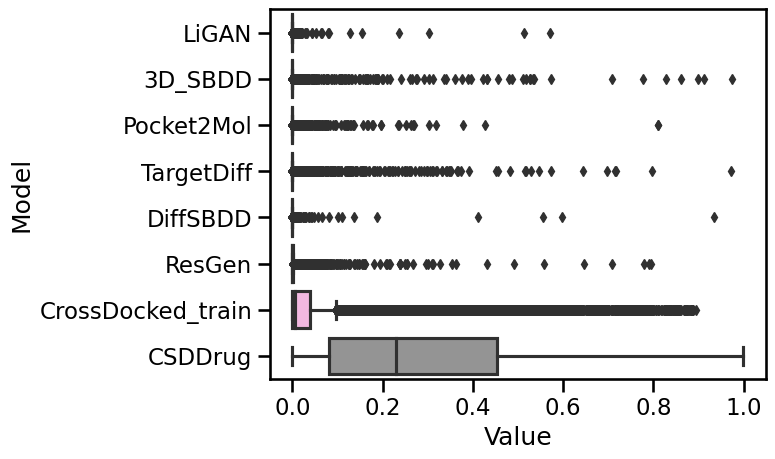

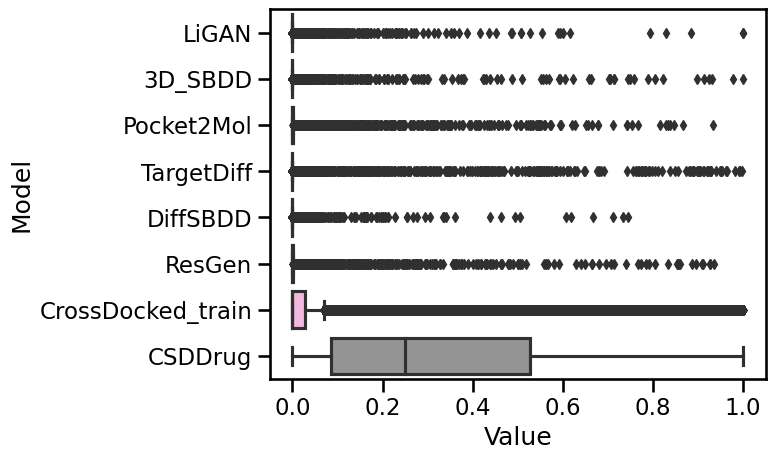

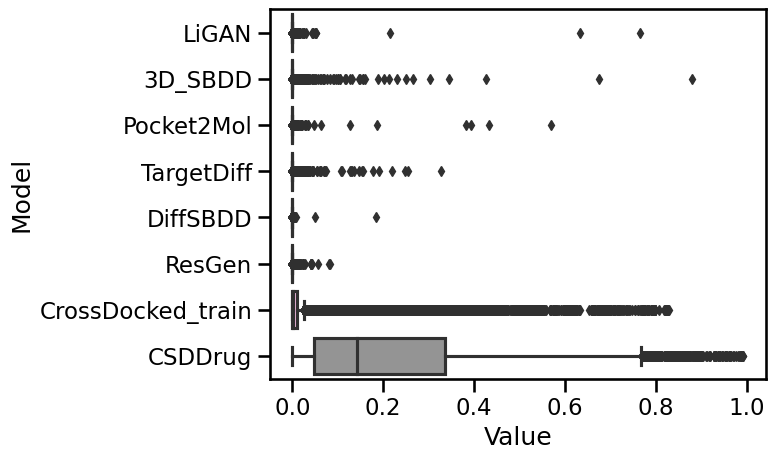

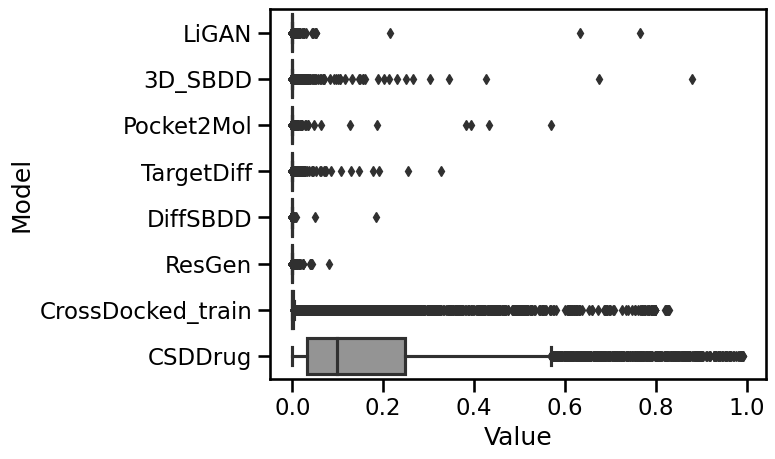

In [43]:
for name in min_df['Name'].unique():
    sns.boxplot(data=min_df[(~min_df['Minimized']) & (min_df['Name'] == name)],
           x='Value',
           y='Model')
    plt.show()

In [44]:
geo_rows = []
for filepath in filepaths:
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    model_name = '_'.join(filepath.split('_')[1:]).split('.')[0]
    minimized = False
    if 'minimized' in model_name:
        minimized = True
        model_name = '_'.join(model_name.split('_')[:-1])
    for name, values in results.items():

        if 'Validity3D CSD' in name:
            name = name.replace('Validity3D CSD', 'Validity3D')
        
        if 'Geometric' in name:
            for value in values:
                row = {'Model' : model_name,
                      'Minimized': minimized,
                      'Name': name,
                      'Value': value}
                geo_rows.append(row)

In [45]:
geo_df = pd.DataFrame(geo_rows)

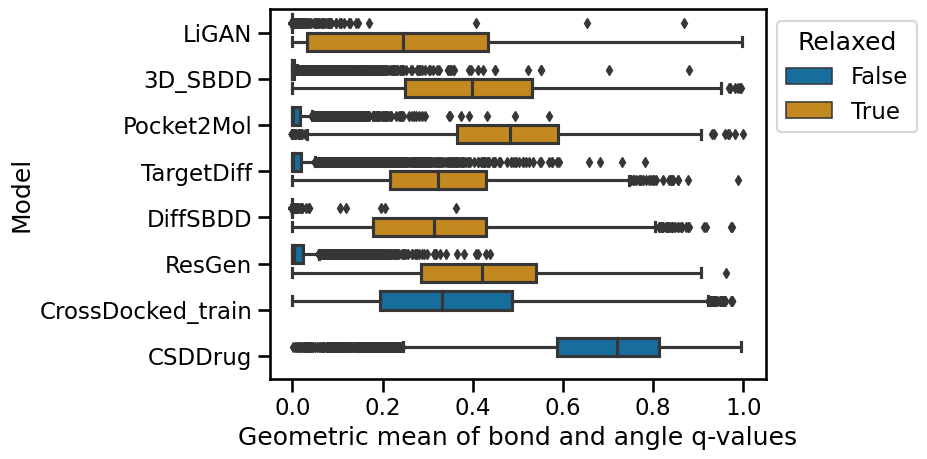

In [46]:
ax = sns.boxplot(data=geo_df[geo_df['Name'] == 'Geometric mean bond+angle q-value (Validity3D)'],
           x='Value',
           y='Model',
           hue='Minimized')
for bars, colors, hatch in zip(ax.containers, (colorblind_palette, colorblind_palette), hatches):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)

# for bars, hatch in zip(ax.containers, hatches):
#      for bar in bars:
#           bar.set_hatch(hatch)
title = 'Subset'
labels = ['Raw', 'Relaxed']
ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), title='Relaxed')

# ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],
#           labels=labels,
#           title=title,
#           handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)},
#          loc="upper left", 
#               bbox_to_anchor=(1, 1))
# plt.xlim(0, 1)
plt.xlabel('Geometric mean of bond and angle q-values')
plt.savefig('figures/geo_q_values.png', dpi=300, bbox_inches='tight')
# for container in ax.containers:
#     ax.bar_label(container)

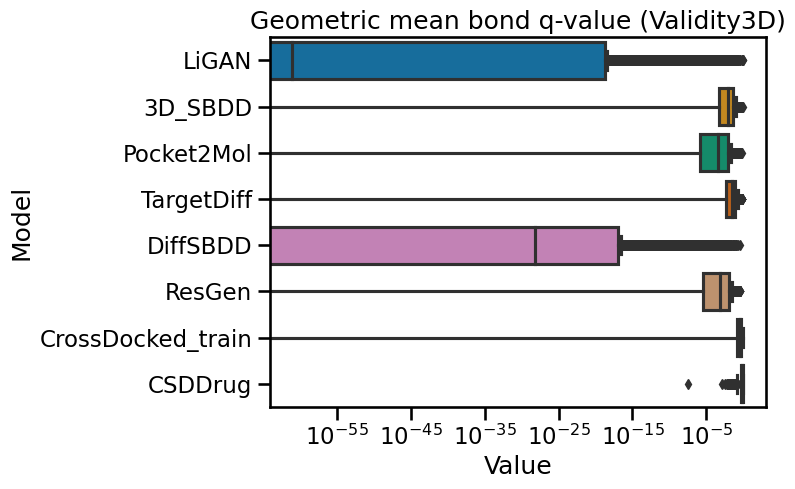

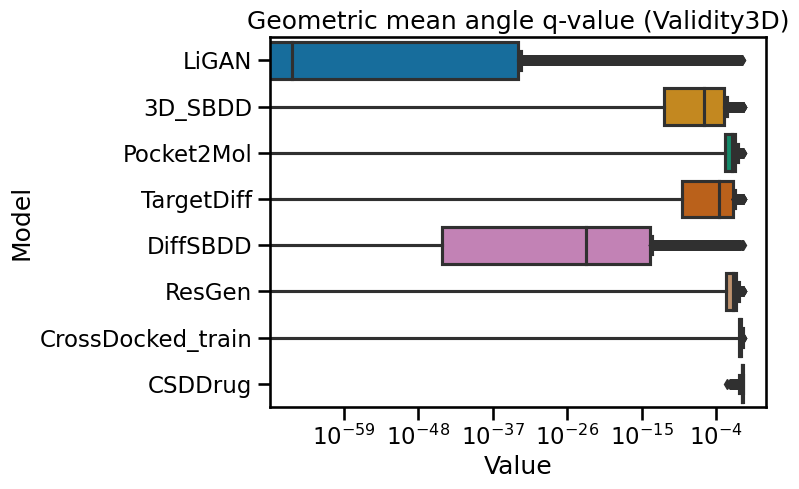

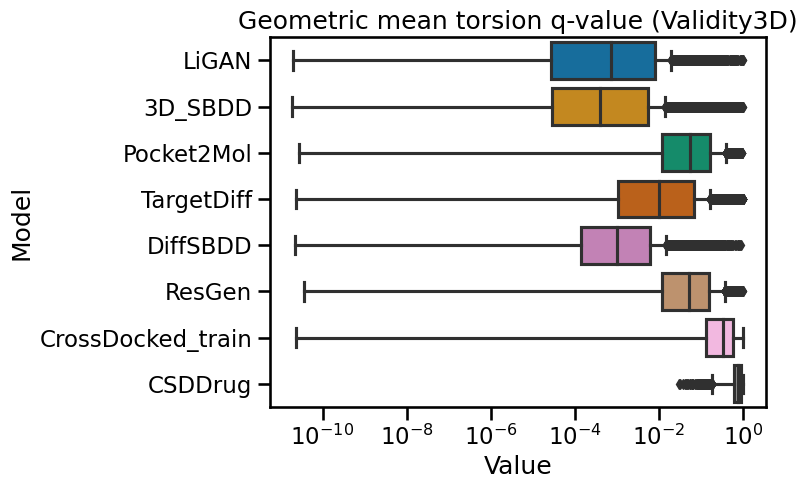

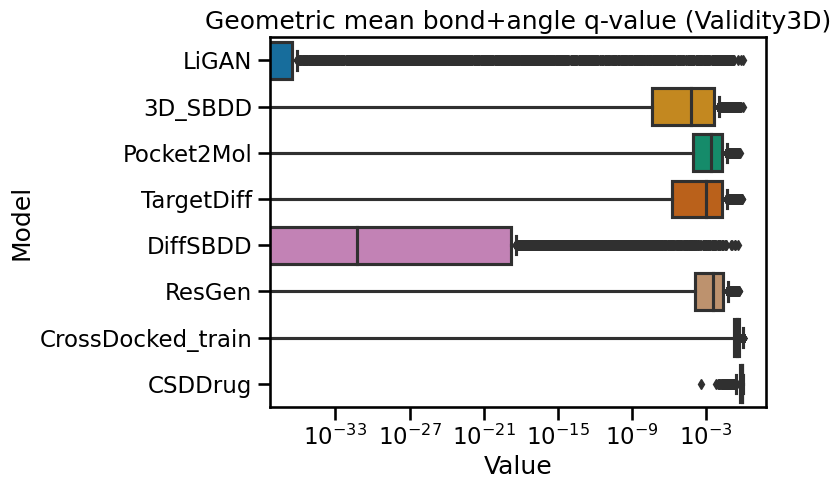

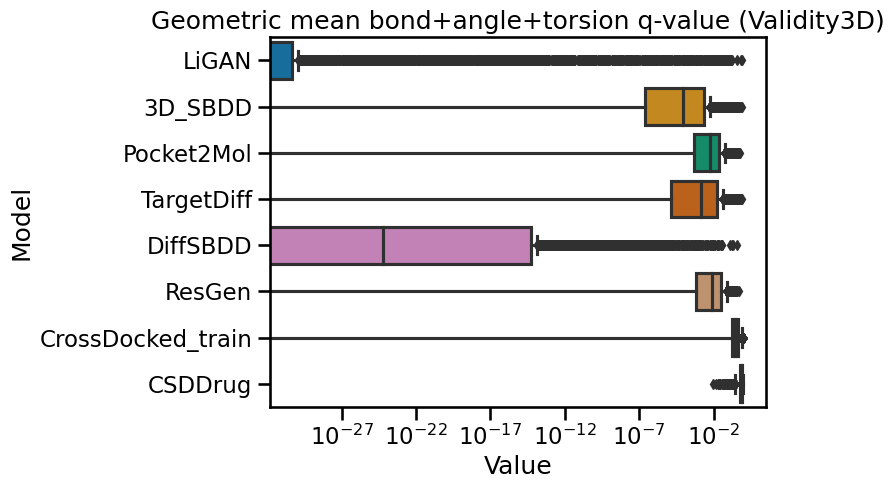

In [47]:
for name in geo_df['Name'].unique():
    f = sns.boxplot(data=geo_df[(~geo_df['Minimized']) & (geo_df['Name'] == name)],
           x='Value',
           y='Model')
    f.set_xscale("log")
    plt.title(name)
    plt.show()